In [42]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import wordcloud

In [43]:
df = pd.read_csv('../database/preprocessed_content_analysis.csv', index_col=0)
df

first_name middle_name   last_name                               email  \
0           Talal         NaN        Asad             talalasad@earthlink.net   
1           Talal         NaN        Asad             talalasad@earthlink.net   
2           Talal         NaN        Asad             talalasad@earthlink.net   
3           Talal         NaN        Asad             talalasad@earthlink.net   
4            Leaf         NaN   Van Boven               vanboven@colorado.edu   
...           ...         ...         ...                                 ...   
115403    Francis           J  Magilligan  francis.j.magilligan@dartmouth.edu   
115404    Francis           J  Magilligan  francis.j.magilligan@dartmouth.edu   
115405    Francis           J  Magilligan  francis.j.magilligan@dartmouth.edu   
115406    Francis           J  Magilligan  francis.j.magilligan@dartmouth.edu   
115407    Francis           J  Magilligan  francis.j.magilligan@dartmouth.edu   

                                   institution  award_year  award_amount  \
0       cuny graduate school university center        2011         19901   
1       cuny graduate school university center        2011         19901   
2       cuny graduate school university center        2011         19901   
3       cuny graduate school university center        2011         19901   
4            university of colorado at boulder        2011        250000   
...                                        ...         ...           ...   
115403                       dartmouth college        2020        427479   
115404                       dartmouth college        2020        427479   
115405                       dartmouth college        2020        427479   
115406                       dartmouth college        2020        427479   
115407                       dartmouth college        2020        427479   

                                              paper_title  \
0       Effect of oxidation and geometrical dimensions...   
1       Synthesis and biological evaluation of new pyr...   
2       Synthesis of 6-Ethyl-1, 2, 9-trioxopyrrolo [3,...   
3       Randa M. Al-As’ ada, Mustafa M. El-abadelaha, ...   
4       Identifiable but not identical: Combining soci...   
...                                                   ...   
115403  Assessing the Impacts of Extreme Precipitation...   
115404  What is Fluvial Geomorphic Equilibrium?: Evalu...   
115405  Bankfull Channel Adjustments to Episodic and L...   
115406  Elevated post-event sediment yield extends the...   
115407  Connectivity in geomorphology. Proceedings of ...   

                                 journal  publication_year  ... citation_2019  \
0                           Desalination              2011  ...            13   
1                              Molecules              2014  ...            13   
2       Zeitschrift für Naturforschung B              2013  ...            13   
3                         Z. Naturforsch              2013  ...            13   
4           Journal of Consumer research              2012  ...           868   
...                                  ...               ...  ...           ...   
115403        AGU Fall Meeting Abstracts              2020  ...           453   
115404        AGU Fall Meeting Abstracts              2019  ...           453   
115405        AGU Fall Meeting Abstracts              2019  ...           453   
115406        AGU Fall Meeting Abstracts              2018  ...           453   
115407                     Geomorphology              2017  ...           453   

       citation_2020  citation_2021  citation_2022  citation_2023  \
0                  5             10              5              7   
1                  5             10              5              7   
2                  5             10              5              7   
3                  5             10              5              7   
4               1234           1132           1198           1222   
.

In [44]:
# prepare data for cluatering
df['normalized_abstract'] = df['normalized_abstract'].apply(ast.literal_eval)
df['normalized_abstract'] = df['normalized_abstract'].apply(lambda x: ' '.join(x))

In [45]:
# group by email and concatenate abstracts
cluster_df = df.groupby('email')['normalized_abstract'].apply(lambda x: '. '.join(x)).reset_index()

In [46]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# generate a sparse TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_df['normalized_abstract'])

# convert the sparse TF-IDF matrix to a dense matrix
tfidf_matrix = tfidf_matrix.toarray()

In [16]:
# fit SVD
n_components = min(tfidf_matrix.shape) - 1
pca = PCA(n_components=n_components)
pca.fit(tfidf_matrix)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# calculate the number of SVD components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

526

In [47]:
# fit and transform TF-IDF matrix
pca = PCA(n_components=526)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix)

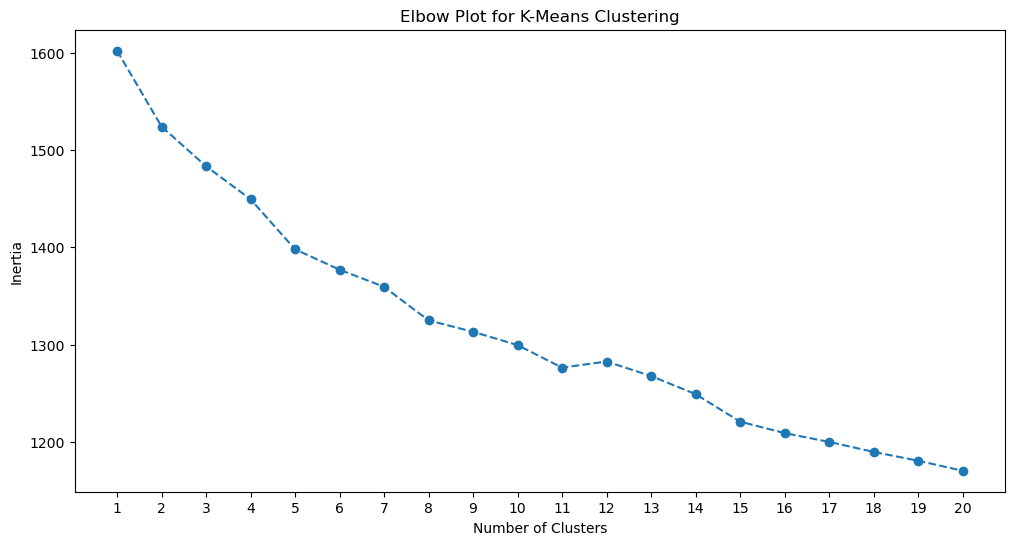

In [18]:
# calculate the inertia for each number of clusters
num_clusters = range(1, 21)
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_reduced)
    inertias.append(kmeans.inertia_)

# plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.xticks(num_clusters)
plt.show()

In [48]:
# perform K-means clustering on the reduced TF-IDF matrix
kmeans_tfidf = KMeans(n_clusters=8, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_reduced)

# add cluster labels to the dataframe
cluster_df['tfidf_cluster'] = kmeans_tfidf.labels_

In [15]:
# function to find the most distinctive words in each cluster
def find_distinctive_words_by_cluster(clusters):
    aggregate_tfidf_vectors_by_cluster = {}
    
    for i, cluster in enumerate(clusters):
        if cluster not in aggregate_tfidf_vectors_by_cluster:
            aggregate_tfidf_vectors_by_cluster[cluster] = tfidf_matrix[i]
        else:
            aggregate_tfidf_vectors_by_cluster[cluster] += tfidf_matrix[i]

    distinctive_words_by_cluster = {}
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    for cluster, agg_tfidf in aggregate_tfidf_vectors_by_cluster.items():
        sorted_indices = np.argsort(agg_tfidf.toarray()).flatten()[::-1]
        distinctive_words_by_cluster[cluster] = feature_names[sorted_indices][:20]

    for cluster, words in distinctive_words_by_cluster.items():
        print(f"Cluster {cluster}: {words}")

In [16]:
# find the most distinctive words in each TF-IDF cluster
find_distinctive_words_by_cluster(cluster_df['tfidf_cluster'])

Cluster 3: ['language' 'linguistic' 'speaker' 'english' 'word' 'verb' 'syntactic'
 'sentence' 'semantic' 'child' 'grammar' 'study' 'l2' 'speech' 'spanish'
 'noun' 'lexical' 'grammatical' 'bilingual' 'learner']
Cluster 7: ['visual' 'memory' 'task' 'brain' 'neural' 'stimulus' 'object' 'model'
 'study' 'participant' 'cortex' 'cognitive' 'control' 'network'
 'experiment' 'human' 'response' 'information' 'performance' 'motor']
Cluster 2: ['child' 'study' 'social' 'health' 'self' 'research' 'woman' 'people'
 'participant' 'emotion' 'behavior' 'group' 'individual' 'examine'
 'infant' 'experience' 'human' 'effect' 'high' 'result']
Cluster 1: ['speech' 'word' 'listener' 'language' 'vowel' 'speaker' 'english'
 'acoustic' 'phonetic' 'auditory' 'sound' 'study' 'child' 'phonological'
 'perception' 'experiment' 'lexical' 'sentence' 'native' 'production']
Cluster 0: ['de' 'la' 'political' 'social' 'en' 'new' 'el' 'economic' 'state' 'que'
 'los' 'urban' 'community' 'food' 'study' 'geography' 'research

In [49]:
# create a cluster mapping
tfidf_cluster_mapping = {
    0: 'Cultural Studies',
    1: 'Phonetics',
    2: 'Psychology',
    3: 'Linguistics',
    4: 'Environmental Studies',
    5: 'Human Biology',
    6: 'Archaeology',
    7: 'Cognitive Neuroscience',
}

# apply the mapping to TF-IDF clusters
cluster_df['tfidf_cluster'] = cluster_df['tfidf_cluster'].map(tfidf_cluster_mapping)

In [50]:
# initiate a TF-IDF vectorizer 
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# generate TF-IDF matrix in sparse format
tfidf_matrix_sparse = tfidf_vectorizer.fit_transform(cluster_df['normalized_abstract'])

# convert the sparse TF-IDF matrix to a dense matrix
tfidf_matrix_dense = tfidf_matrix_sparse.toarray()

# reduce the TF-IDF matrix to 2 dimensions using PCA
pca = PCA(n_components=2, random_state=42)
tfidf_matrix_2D = pca.fit_transform(tfidf_matrix_dense)

# apply k-means clustering on the reduced data
kmeans_tfidf = KMeans(n_clusters=8, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_2D)

KMeans(random_state=42)

In [51]:
# cluster assignments
y_kmeans_tfidf = kmeans_tfidf.predict(tfidf_matrix_2D)

# calculate the size for each cluster
sizes = [np.sum(y_kmeans_tfidf == i) for i in range(kmeans_tfidf.n_clusters)]

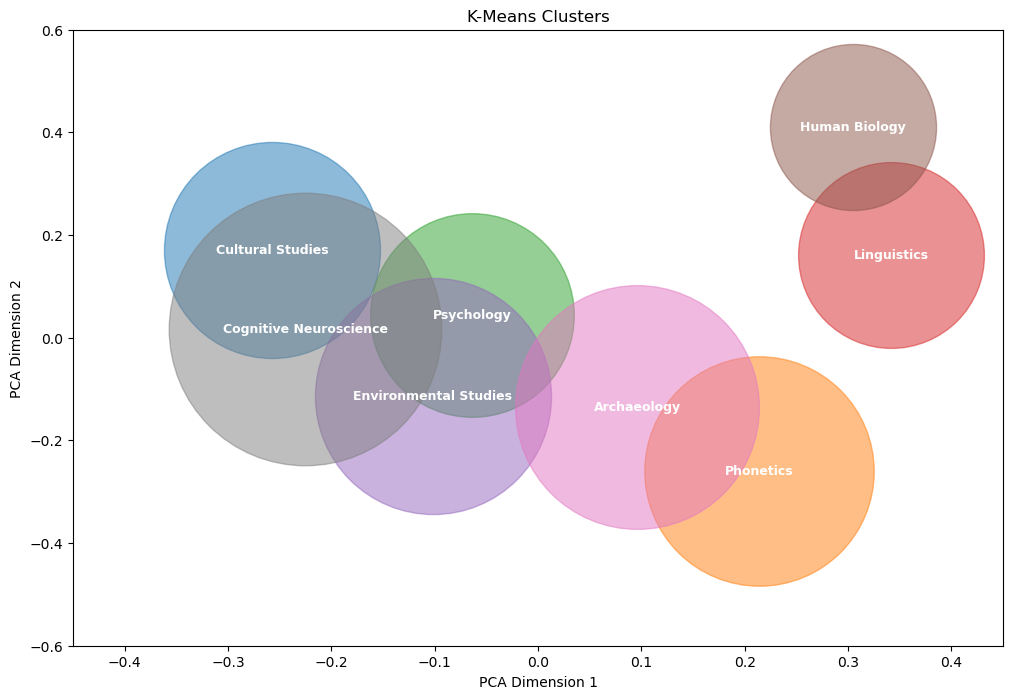

In [52]:
# visualization
plt.figure(figsize=(12, 8))

# define a colormap
colors = plt.cm.tab10.colors

# plot each cluster with a different color and size
for i in range(kmeans_tfidf.n_clusters):
    centroid = kmeans_tfidf.cluster_centers_[i]
    size = sizes[i] * 100 
    plt.scatter(centroid[0], centroid[1], s=size, label=f'Cluster {i}', alpha=0.5, color=colors[i % len(colors)])
    plt.text(centroid[0], centroid[1], tfidf_cluster_mapping[i], ha='center', va='center', color='white', fontsize=9, weight='bold')

plt.xlim(-0.45, 0.45)
plt.ylim(-0.6, 0.6)

plt.title('K-Means Clusters')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

In [11]:
# prepare data for WordCloud
cluster_df['normalized_abstract'] = cluster_df['normalized_abstract'].str.split(' ')

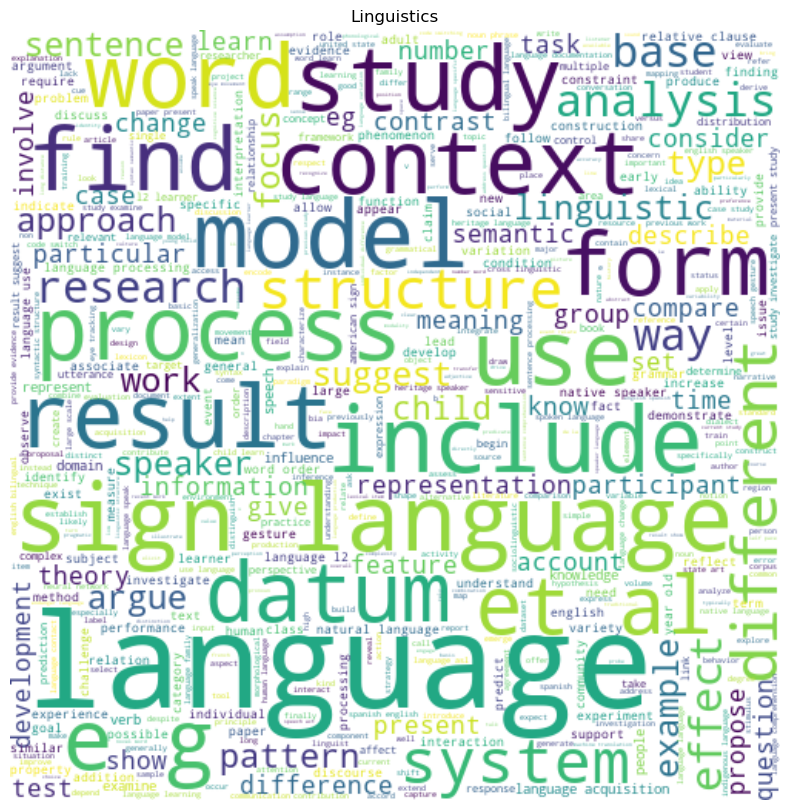

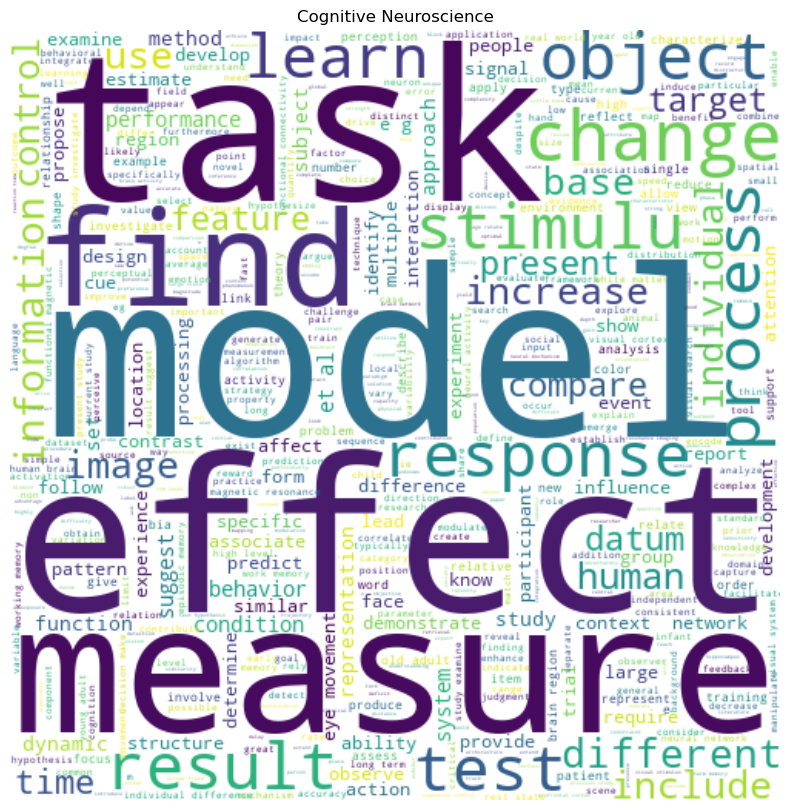

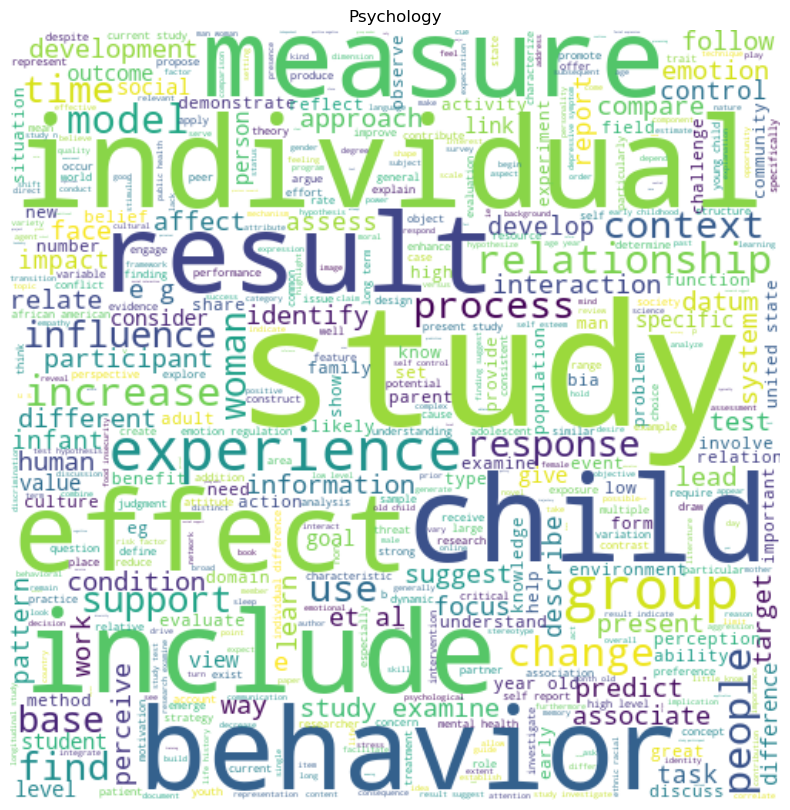

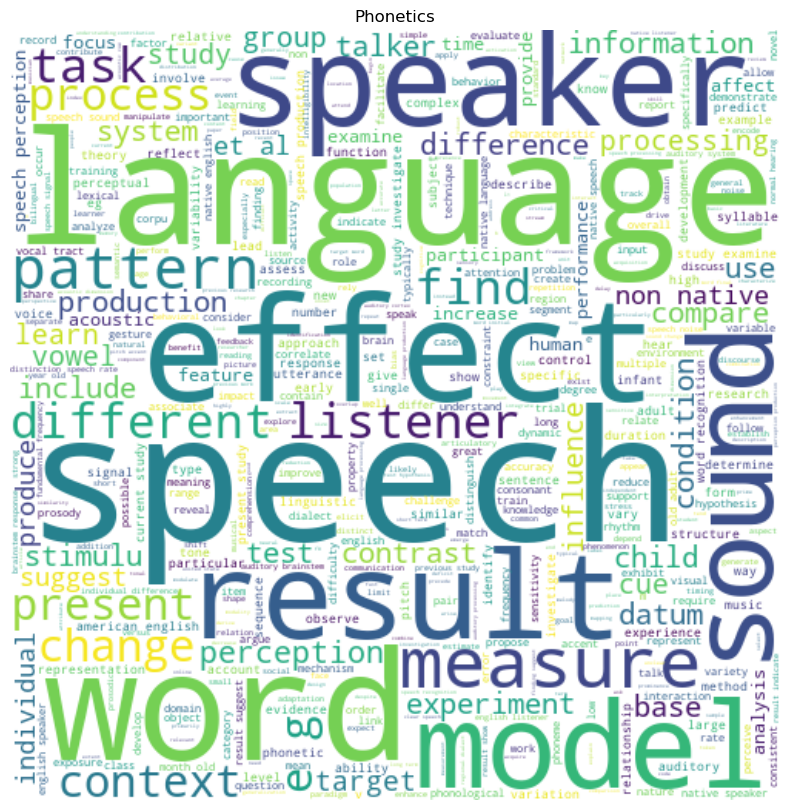

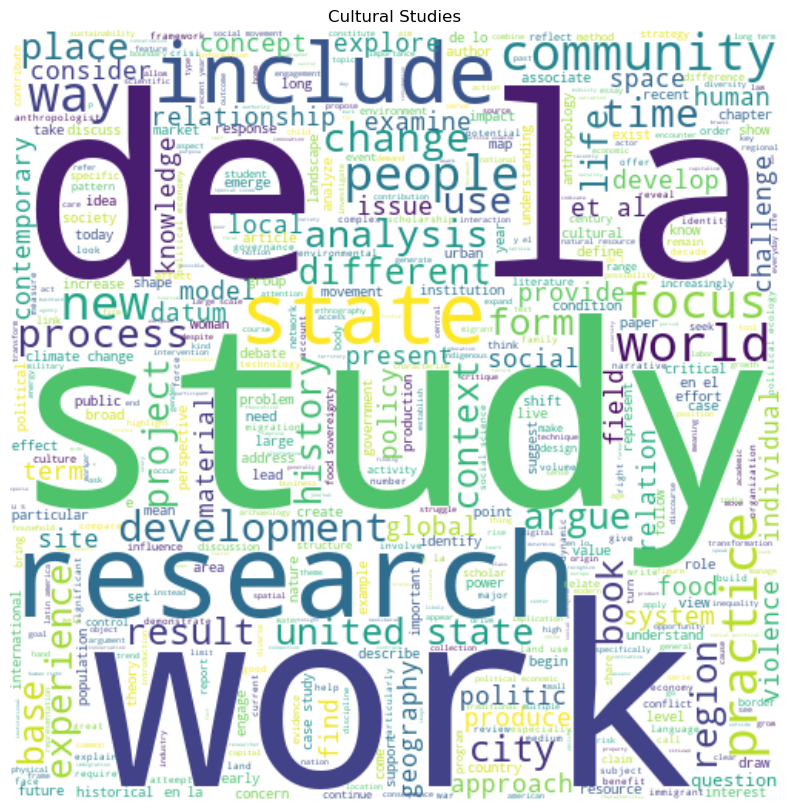

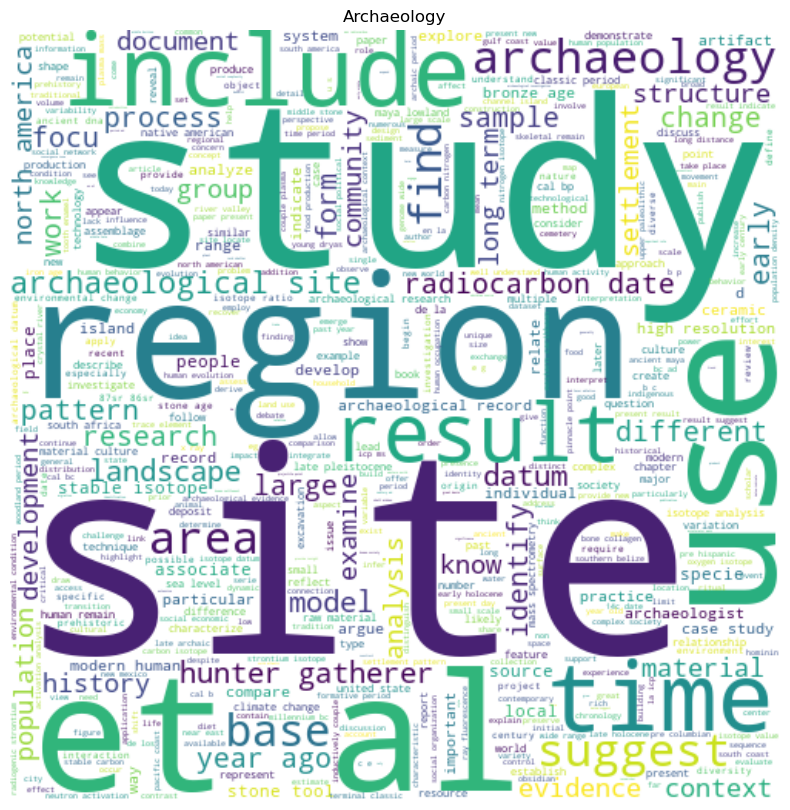

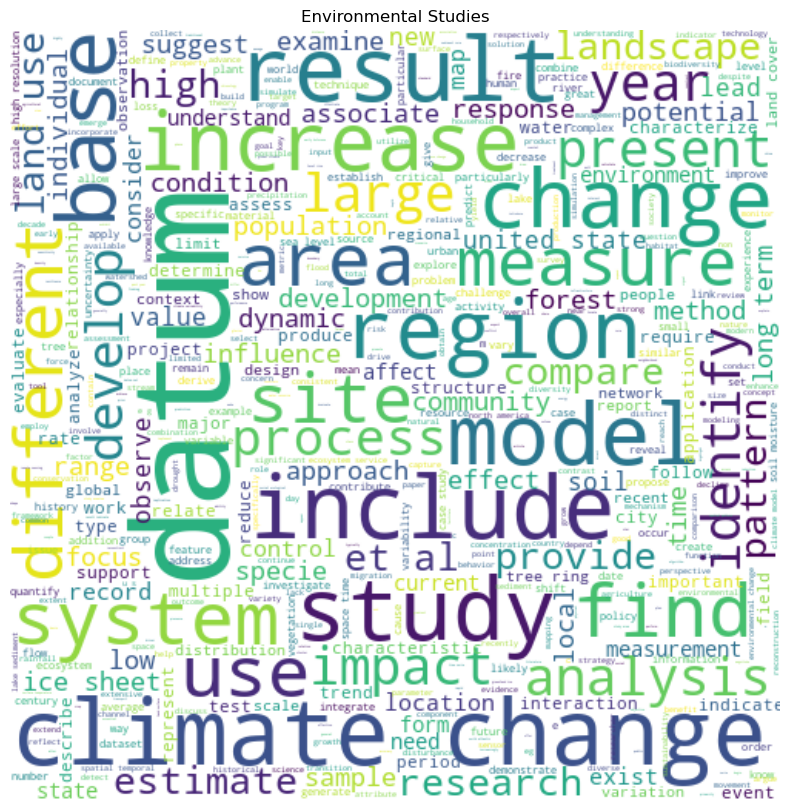

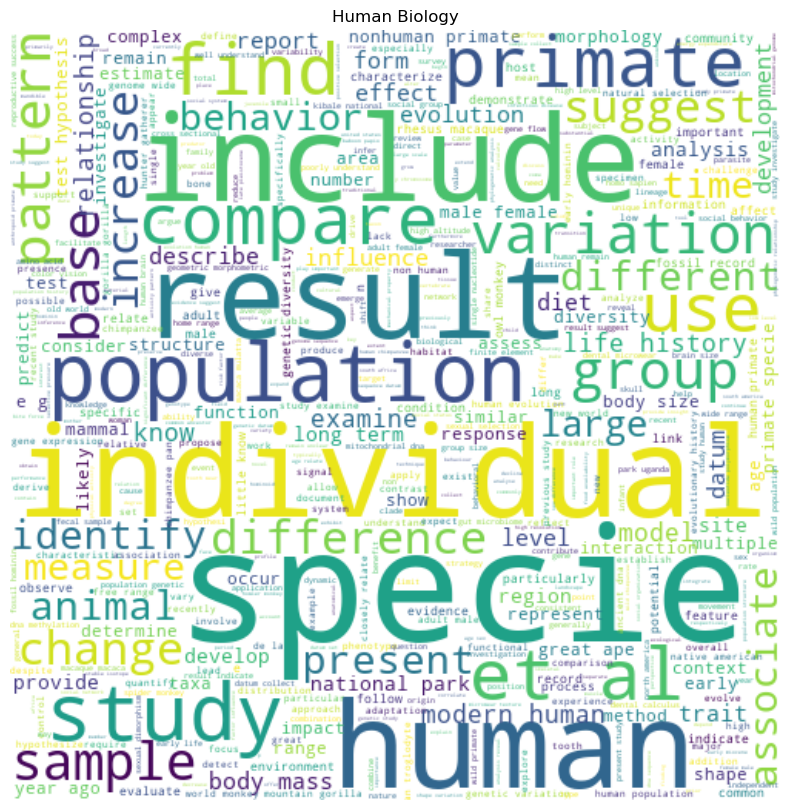

In [38]:
# find all labels
labels = cluster_df['tfidf_cluster'].unique()

# reset sns
sns.reset_orig()

# generate a word cloud for each cluster
for label in labels:
    subset = cluster_df[cluster_df['tfidf_cluster'] == label]
    text = ' '.join(subset['normalized_abstract'].sum())

    # create a WordCloud object
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=.5).generate(text)
    
    # display the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'{label}')
    plt.show()

In [27]:
author_df = pd.read_csv('../database/author_info.csv', index_col=0)
author_df['interests'] = author_df['interests'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
author_df

first_name middle_name   last_name                               email  \
0         Talal         NaN        Asad             talalasad@earthlink.net   
1          Leaf         NaN   Van Boven               vanboven@colorado.edu   
2        Steven         NaN     Bedrick                   bedricks@ohsu.edu   
3        George           R      Milner                         ost@psu.edu   
4        Shelly         NaN       Gable                gable@psych.ucsb.edu   
...         ...         ...         ...                                 ...   
3225       Dana           E      Powell               powellde@appstate.edu   
3226     Daniel         NaN      Murphy               murphdl@ucmail.uc.edu   
3227    Jeffrey         NaN     Winking                   jwinking@tamu.edu   
3228    Yongwan         NaN        Chun                 ywchun@utdallas.edu   
3229    Francis           J  Magilligan  Francis.J.Magilligan@Dartmouth.EDU   

                                  institution  \
0      CUNY Graduate School University Center   
1           University of Colorado at Boulder   
2          Oregon Health & Science University   
3     Pennsylvania State Univ University Park   
4      University of California-Santa Barbara   
...                                       ...   
3225             Appalachian State University   
3226     University of Cincinnati Main Campus   
3227                 Texas A&amp;M University   
3228            University of Texas at Dallas   
3229                        Dartmouth College   

                                                    url  total_citations  \
0     https://scholar.google.com/citations?hl=en&use...              106   
1     https://scholar.google.com/citations?hl=en&use...            12916   
2     https://scholar.google.com/citations?hl=en&use...             2230   
3     https://scholar.google.com/citations?hl=en&use...             9549   
4     https://scholar.google.com/citations?hl=en&use...            30300   
...                                                 ...              ...   
3225  https://scholar.google.com/citations?hl=en&use...              934   
3226  https://scholar.google.com/citations?hl=en&use...              497   
3227  https://scholar.google.com/citations?hl=en&use...             1987   
3228  https://scholar.google.com/citations?hl=en&use...             2678   
3229  https://scholar.google.com/citations?hl=en&use...             6160   

      h_index                                          interests  \
0           3                                [organic chemistry]   
1          46  [Social psychology, judgment and decision maki...   
2          21                         [NLP, Medical Informatics]   
3          42  [Archaeology (eastern North America, Warfare, ...   
4          54                                                NaN   
...       ...                                                ...   
3225       11  [environmental justice, ethnography, STS, Nava...   
3226       12  [anthropology, climate change, risk and uncert...   
3227       22                                                NaN   
3228       25   [GIS, Spatial Statistics, Spatial Data Analysis]   
3229       45                                                NaN   

      citation_2011  ...  citation_2004  citation_2005  citation_2006  \
0               2.0  ...            NaN            NaN            NaN   
1             363.0  ...           74.0          127.0          157.0   
2              63.0  ...            NaN            6.0           10.0   
3             295.0  ...          151.0          184.0          203.0   
4            1119.0  ...          230.0          313.0          533.0   
...             ...  ...            ...            ...            ...   
3225           17.0  ...            NaN            NaN            NaN   
3226            NaN  ...            NaN            NaN            NaN   
3227           98.0  ...            NaN            NaN            5.0   
3228   

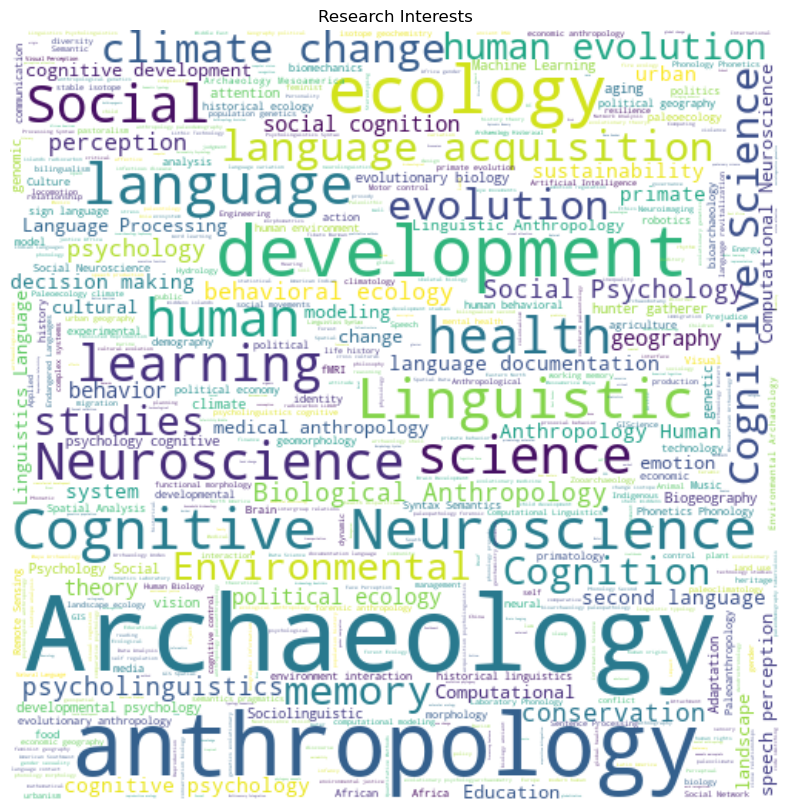

In [39]:
# reset sns
sns.reset_orig()

# create a Wordcloud object
text = ' '.join([' '.join(interest) for interest in author_df['interests'].dropna()])
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=.5).generate(text)

# display the generated word cloud:
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title(f'Research Interests')
plt.show()

In [30]:
# create a dataframe for 'journal' visualization 
journal_df = df.groupby('email')['journal'].apply(list).reset_index()
journal_df = pd.merge(cluster_df, journal_df, on='email', how='left')
journal_df

email  \
0                 00t0holtgrav@bsu.edu   
1           a.satpute@northeastern.edu   
2                     aabrewer@uci.edu   
3                         aag6@psu.edu   
4                 aam72@georgetown.edu   
...                                ...   
2029               zkrizan@iastate.edu   
2030                 zoe.wool@rice.edu   
2031                      zook@uky.edu   
2032                      zulu@msu.edu   
2033  zygmunt.frajzyngier@colorado.edu   

                                    normalized_abstract  \
0     [interdisciplinary, synthesis, social, psychol...   
1     [emotion, assume, manifest, subcortical, limbi...   
2     [functional, organization, human, auditory, co...   
3     [decade, introduction, concept, emotional, lab...   
4     [autism, spectrum, disorder, asds, characteriz...   
...                                                 ...   
2029  [narcissism, spectrum, model, synthesize, exte...   
2030  [war, zoë, h., wool, explore, american, soldie...   
2031  [paper, outline, way, information, technologie...   
2032  [urban, household, sub, saharan, africa, use, ...   
2033  [hdi, hitherto, undescribe, language, speak, n...   

               tfidf_cluster  \
0                Linguistics   
1     Cognitive Neuroscience   
2     Cognitive Neuroscience   
3                 Psychology   
4                 Psychology   
...                      ...   
2029              Psychology   
2030        Cultural Studies   
2031        Cultural Studies   
2032   Environmental Studies   
2033             Linguistics   

                                                journal  
0     [journal not found, Journal of gambling studie...  
1     [journal not found, journal not found, journal...  
2     [journal not found, Frontiers in psychology, A...  
3     [journal not found, Journal of occupational he...  
4     [Development and Psychopathology, JAMA Psychia...  
...                                                 ...  
2029  [journal not found, Perspectives on Psychologi...  
2030  [journal not found, Critical Military Studies,...  
2031  [World Medical & Health Policy, Cambridge jour...  
2032  [journal not found, journal not found, BMC inf...  
2033  [journal not found, journal not found, journal...  

[2034 rows x 4 columns]

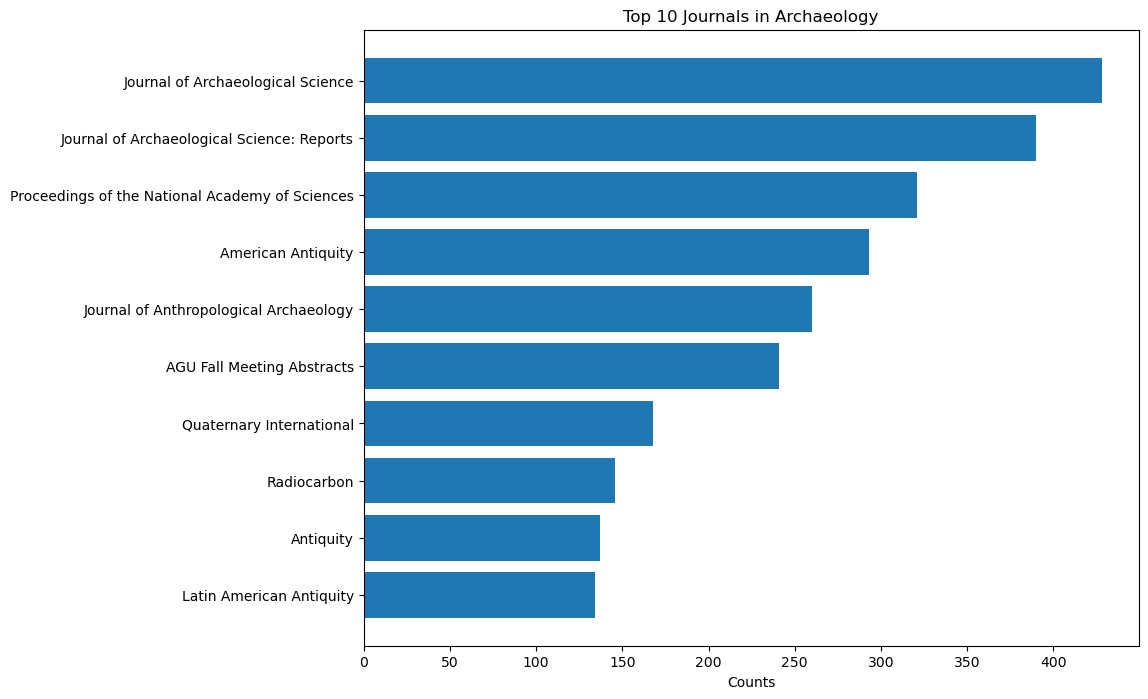

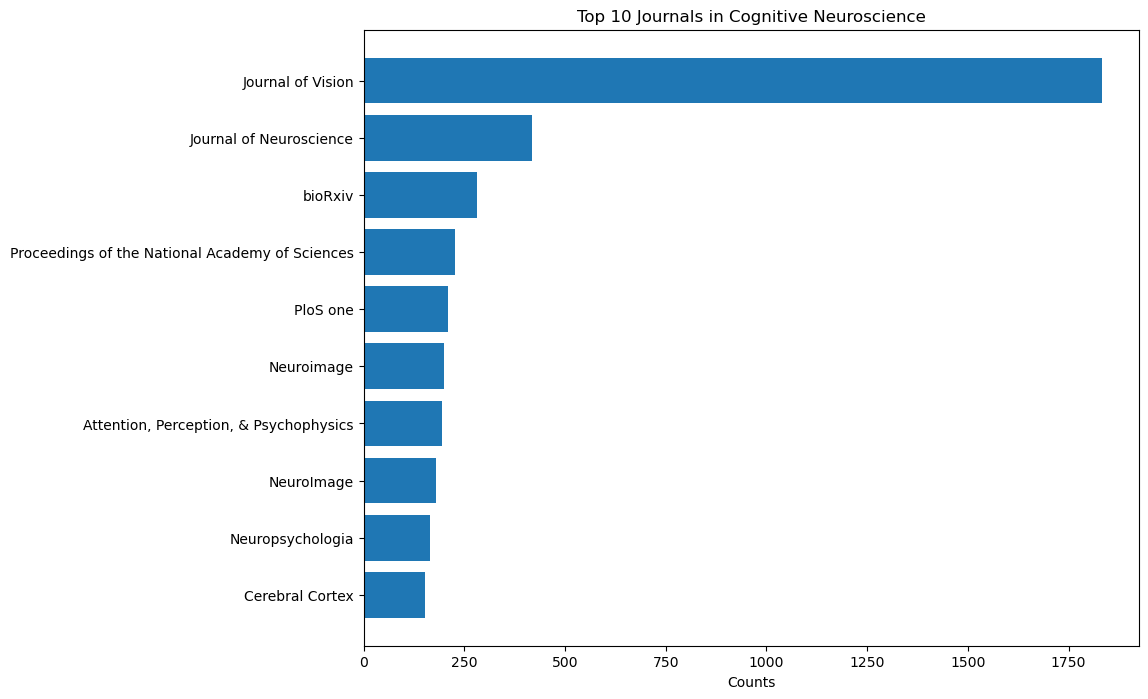

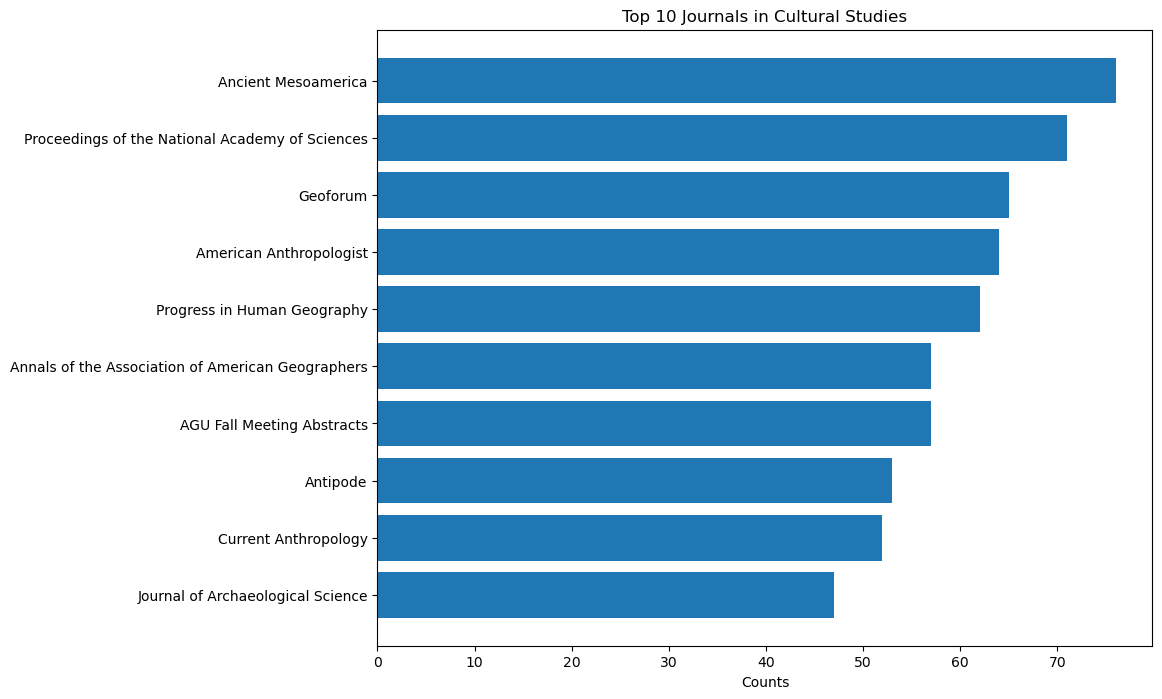

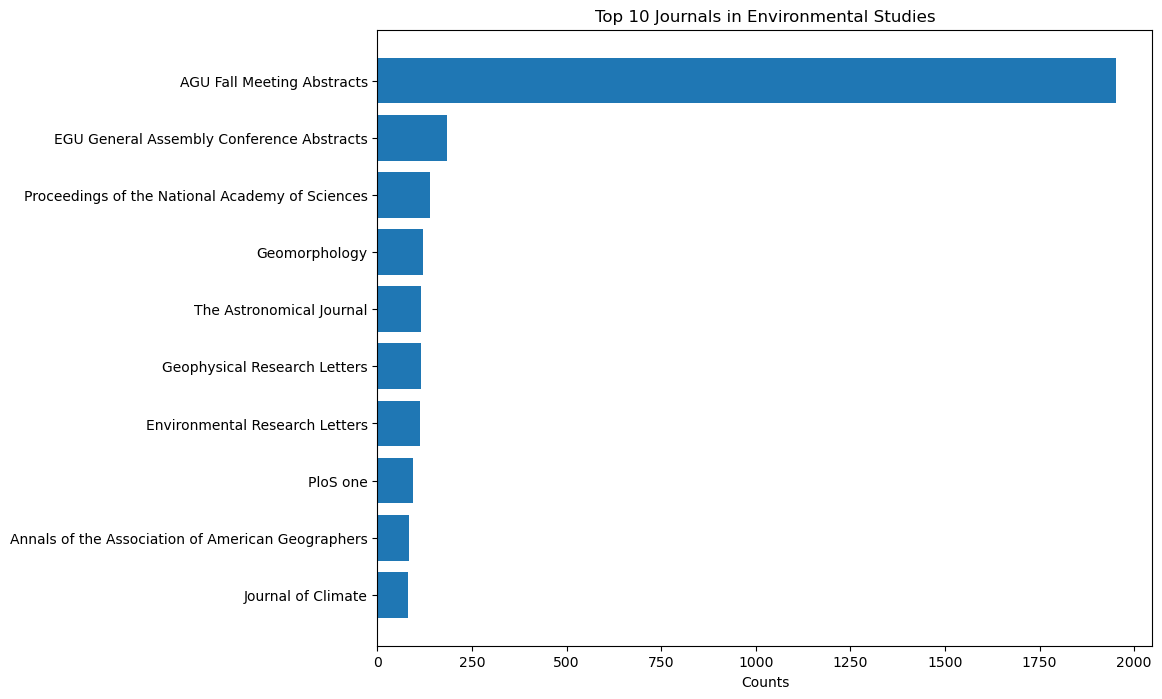

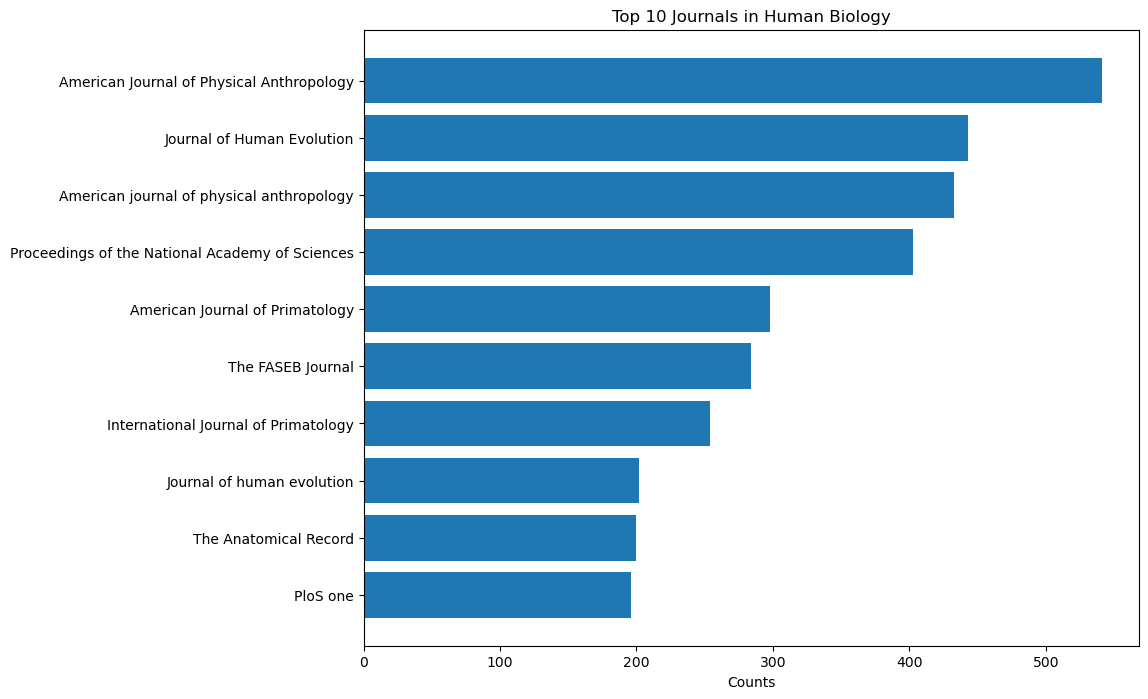

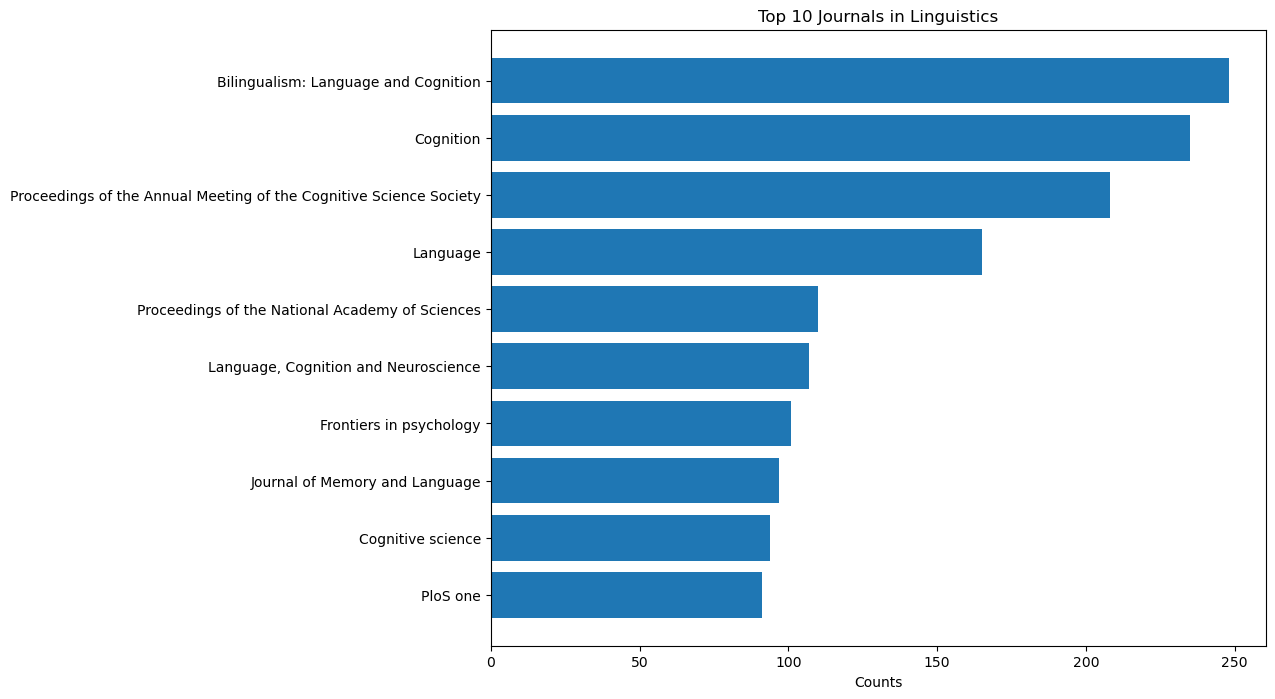

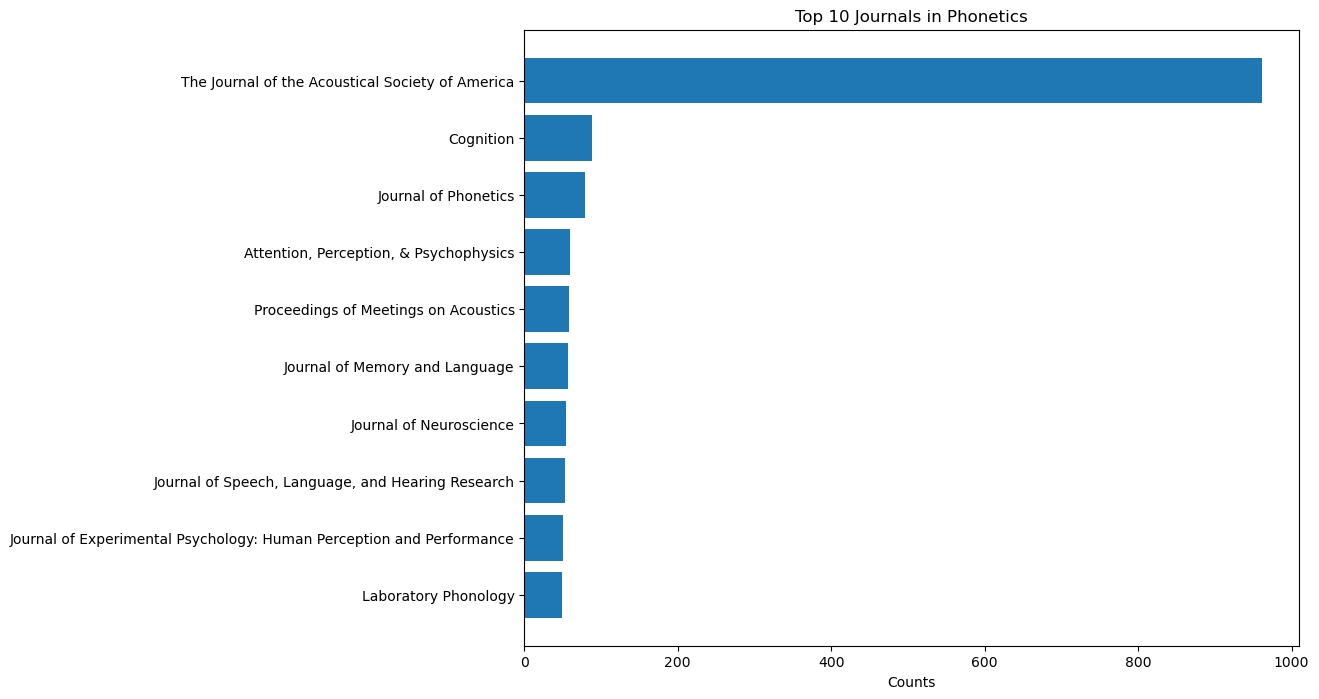

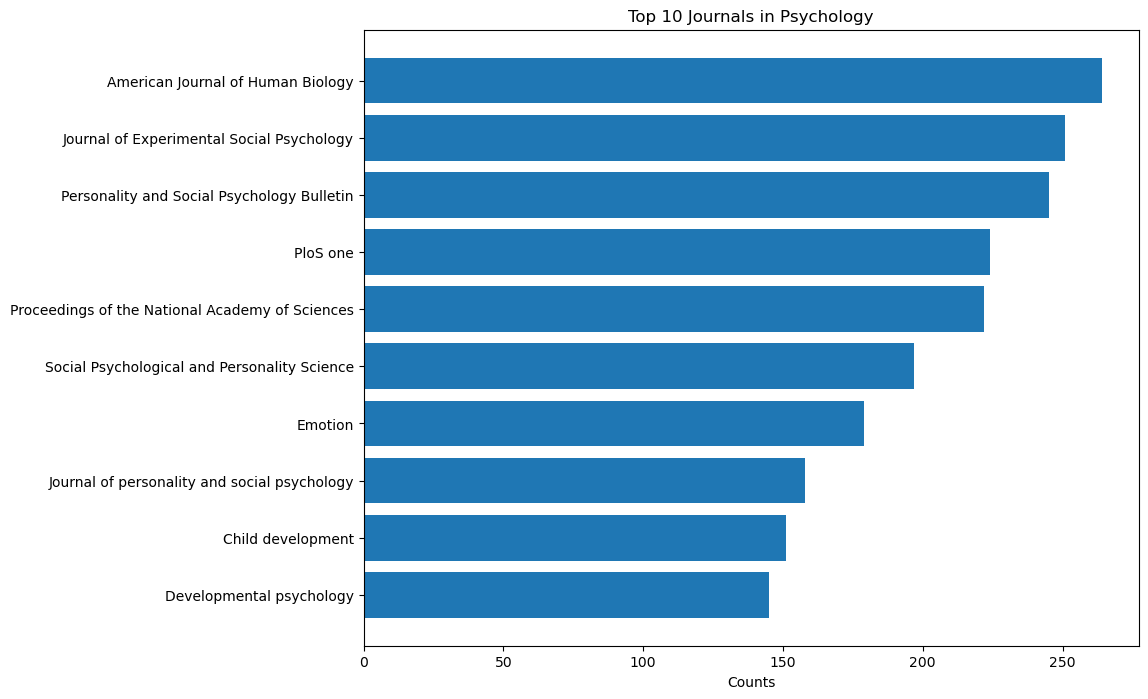

In [32]:
# flatten lists in 'journal' column
expanded_rows = journal_df.explode('journal')

# remove 'journal not found' entries
cleaned_rows = expanded_rows[expanded_rows['journal'] != 'journal not found']

# count the occurrences of each journal within each cluster
journal_counts = cleaned_rows.groupby(['tfidf_cluster', 'journal']).size().reset_index(name='counts')

# identify the top 10 journals for each cluster
top_journals = journal_counts.groupby('tfidf_cluster').apply(lambda x: x.nlargest(10, 'counts')).reset_index(drop=True)

# plot the bar graphs for each cluster
clusters = top_journals['tfidf_cluster'].unique()
for cluster in clusters:
    plt.figure(figsize=(10, 8))
    cluster_data = top_journals[top_journals['tfidf_cluster'] == cluster]
    cluster_data = cluster_data.sort_values('counts', ascending=True)
    plt.barh(cluster_data['journal'], cluster_data['counts'])
    plt.xlabel('Counts')
    plt.title(f'Top 10 Journals in {cluster}')
    plt.show()

In [35]:
# create a dataframe for 'award_amount' visualization
award_df = df.groupby('email')['award_amount'].sum().reset_index()
award_df = pd.merge(cluster_df, award_df, on='email', how='left')
award_df

email  \
0                 00t0holtgrav@bsu.edu   
1           a.satpute@northeastern.edu   
2                     aabrewer@uci.edu   
3                         aag6@psu.edu   
4                 aam72@georgetown.edu   
...                                ...   
2029               zkrizan@iastate.edu   
2030                 zoe.wool@rice.edu   
2031                      zook@uky.edu   
2032                      zulu@msu.edu   
2033  zygmunt.frajzyngier@colorado.edu   

                                    normalized_abstract  \
0     [interdisciplinary, synthesis, social, psychol...   
1     [emotion, assume, manifest, subcortical, limbi...   
2     [functional, organization, human, auditory, co...   
3     [decade, introduction, concept, emotional, lab...   
4     [autism, spectrum, disorder, asds, characteriz...   
...                                                 ...   
2029  [narcissism, spectrum, model, synthesize, exte...   
2030  [war, zoë, h., wool, explore, american, soldie...   
2031  [paper, outline, way, information, technologie...   
2032  [urban, household, sub, saharan, africa, use, ...   
2033  [hdi, hitherto, undescribe, language, speak, n...   

               tfidf_cluster  award_amount  
0                Linguistics      10130760  
1     Cognitive Neuroscience      27999930  
2     Cognitive Neuroscience      11898950  
3                 Psychology       1150128  
4                 Psychology      15220647  
...                      ...           ...  
2029              Psychology      12308114  
2030        Cultural Studies       7999872  
2031        Cultural Studies      12794103  
2032   Environmental Studies        415714  
2033             Linguistics        346579  

[2034 rows x 4 columns]

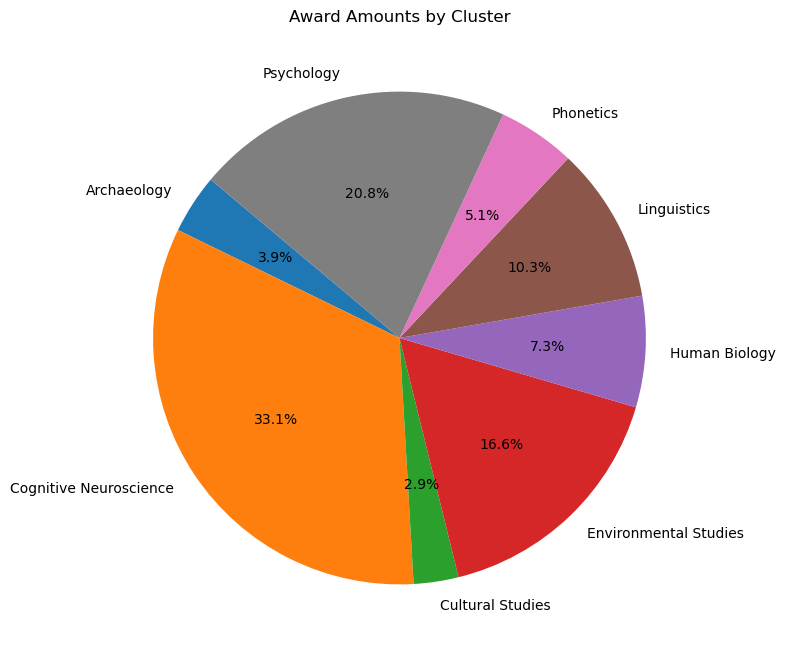

In [37]:
# group 'award_amount' by cluster
award_sums = award_df.groupby('tfidf_cluster')['award_amount'].sum()

# plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(award_sums, labels=award_sums.index, autopct='%1.1f%%', startangle=140)
plt.title('Award Amounts by Cluster')
plt.show()

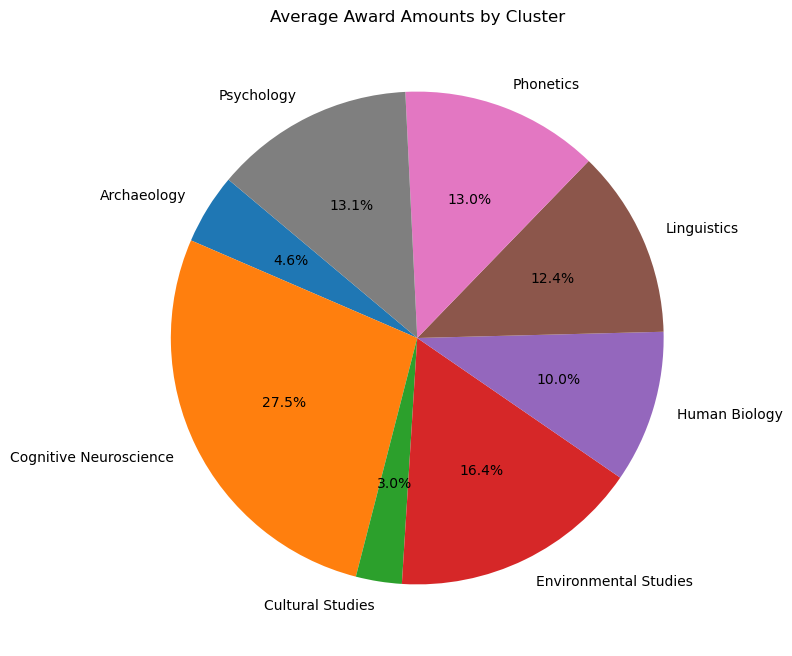

In [41]:
# calculate the average 'award_amount' for each cluster
award_averages = award_df.groupby('tfidf_cluster')['award_amount'].mean()

# plot the pie chart for the average amounts
plt.figure(figsize=(8, 8))
plt.pie(award_averages, labels=award_averages.index, autopct='%1.1f%%', startangle=140)
plt.title('Average Award Amounts by Cluster')
plt.show()

In [23]:
#cluster_df.to_csv('cluster_by_author.csv')